In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm

from src.utils import visualize_batch
from src.dataset import OxfordPetCustom
from src.models import ClassificationModel
from src.utils import plot_confusion_matrix

/home/avishka/anaconda3/envs/wm/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset

In [2]:
device = "cuda"
batch_size = 32


In [3]:
train_dataset = OxfordPetCustom("data/oxford-iiit-pet/images", "train")
val_dataset = OxfordPetCustom("data/oxford-iiit-pet/images", "val")
test_dataset = OxfordPetCustom("data/oxford-iiit-pet/images", "test")

In [4]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

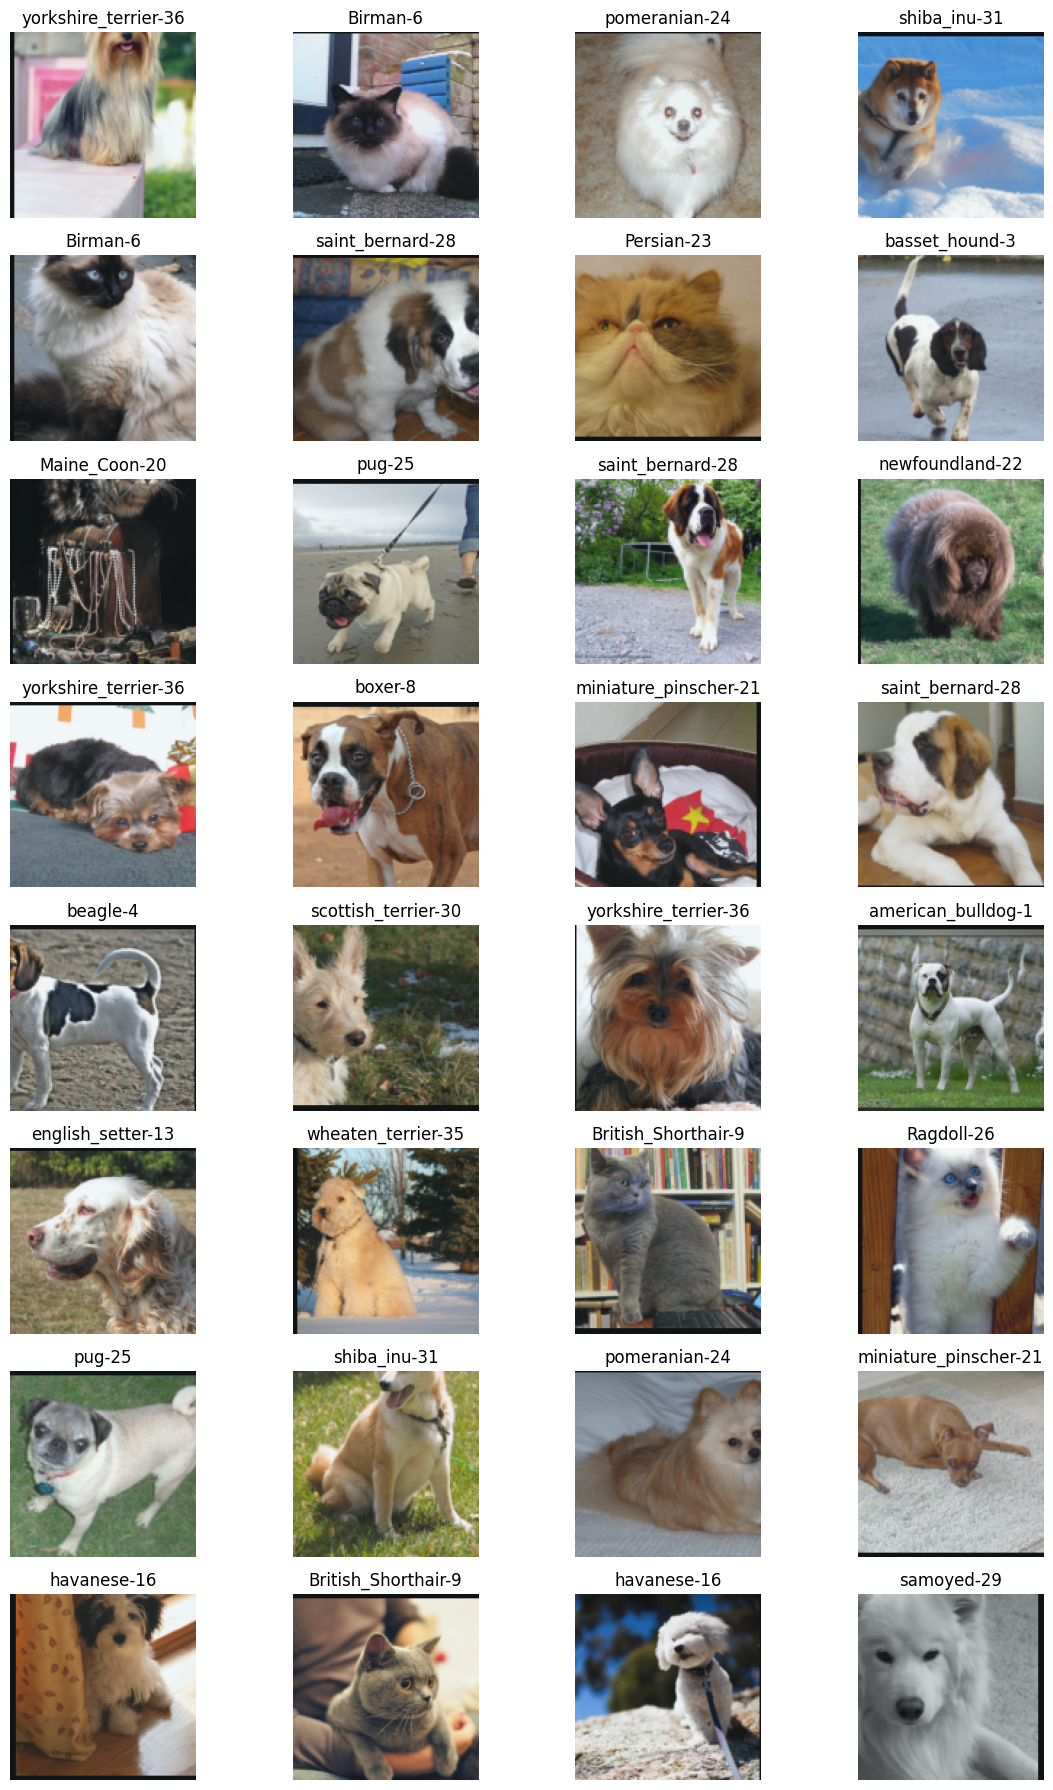

In [5]:
for batch in enumerate(train_loader):
    visualize_batch(batch)
    break

## KNN

In [6]:
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
model = ClassificationModel(backbone, mode="pretrained_encoder").to(
    device
)  ##out_dim = (2048,)

/home/avishka/anaconda3/envs/wm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
embeddings = []
true_labels = []

for batch in enumerate(train_loader):
    _, (imgs, labels) = batch
    imgs = imgs.to(device)
    emb = model(imgs).detach().cpu()
    embeddings += emb
    true_labels += labels

In [8]:
emb.shape

torch.Size([20, 2048])

In [9]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=37)
neigh.fit(embeddings, true_labels)

KNeighborsClassifier(n_neighbors=37)

### Validation

In [9]:
embs = []
true_labels_val = []
for batch in enumerate(val_loader):
    i, (imgs, labels) = batch
    imgs = imgs.to(device)
    emb = model(imgs).detach().cpu()
    embs.append(emb)
    true_labels_val += labels

embs = torch.cat(embs, 0)

In [10]:
yhat = neigh.predict(embs)
yhat

array([18,  1,  5, ...,  7,  4, 25])

Validation Accuracy = 69.585%


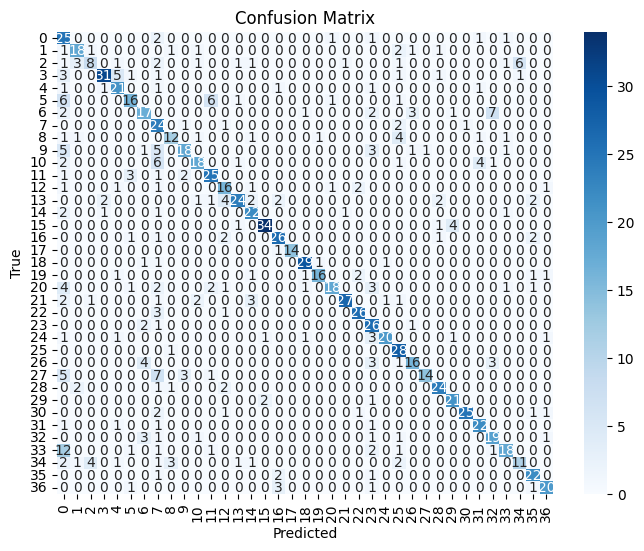

In [17]:
equality_list = [elem1 == elem2 for elem1, elem2 in zip(yhat, true_labels_val)]
print(f"Validation Accuracy = {(sum(equality_list) / len(equality_list)) * 100:.3f}%")
plot_confusion_matrix(true_labels_val, yhat)

### Test

In [18]:
embs = []
true_labels_test = []
for batch in enumerate(test_loader):
    i, (imgs, labels) = batch
    imgs = imgs.to(device)
    emb = model(imgs).detach().cpu()
    embs.append(emb)
    true_labels_test += labels

embs = torch.cat(embs, 0)

In [19]:
yhat = neigh.predict(embs)
yhat

array([22, 19, 20, ..., 16, 19, 10])

Validation Accuracy = 65.104%


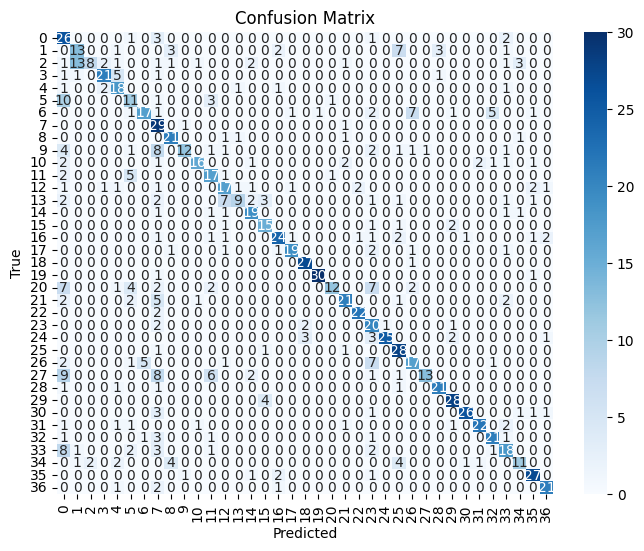

In [20]:
equality_list = [elem1 == elem2 for elem1, elem2 in zip(yhat, true_labels_test)]
print(f"Validation Accuracy = {(sum(equality_list) / len(equality_list)) * 100:.3f}%")
plot_confusion_matrix(true_labels_test, yhat)

## Finetune projection head only

In [8]:
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
model = ClassificationModel(backbone, mode="tune_dec").to(device)

/home/avishka/anaconda3/envs/wm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [10]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch in tqdm(enumerate(train_loader), desc="Train", total=len(train_loader)):
        _, (imgs, labels) = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in tqdm(
            enumerate(val_loader), desc="Validation", total=len(val_loader)
        ):
            _, (imgs, labels) = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.7835
Validation Accuracy: 71.48%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2/10], Loss: 1.2305
Validation Accuracy: 75.27%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3/10], Loss: 1.0826
Validation Accuracy: 76.26%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.8238
Validation Accuracy: 77.26%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.7000
Validation Accuracy: 78.16%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.5424
Validation Accuracy: 78.25%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.7323
Validation Accuracy: 78.34%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.7321
Validation Accuracy: 79.96%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.8944
Validation Accuracy: 79.96%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.7342
Validation Accuracy: 79.87%


### test

In [ ]:
model.eval()
yhat = []
true_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch in tqdm(enumerate(test_loader), desc="Test", total=len(test_loader)):
        _, (imgs, labels) = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        yhat += predicted.detach().cpu()
        true_labels += labels.detach().cpu()

    accuracy = correct / total

print(f"Test Accuracy = {accuracy * 100:.3f}%")
plot_confusion_matrix(true_labels, yhat)

## Finetune full model

In [5]:
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
model = ClassificationModel(backbone, mode="tune_enc_dec").to(device)

/home/avishka/anaconda3/envs/wm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [7]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch in tqdm(enumerate(train_loader), desc="Train", total=len(train_loader)):
        _, (imgs, labels) = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in tqdm(
            enumerate(val_loader), desc="Validation", total=len(val_loader)
        ):
            _, (imgs, labels) = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6858
Validation Accuracy: 85.38%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.4016
Validation Accuracy: 84.03%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.4282
Validation Accuracy: 85.20%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.2312
Validation Accuracy: 86.73%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.3105
Validation Accuracy: 88.45%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.1242
Validation Accuracy: 87.82%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0388
Validation Accuracy: 88.63%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0264
Validation Accuracy: 88.81%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0477
Validation Accuracy: 89.44%


Train:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0167
Validation Accuracy: 89.71%


### Test

Test:   0%|          | 0/18 [00:00<?, ?it/s]

Test Accuracy = 90.442%


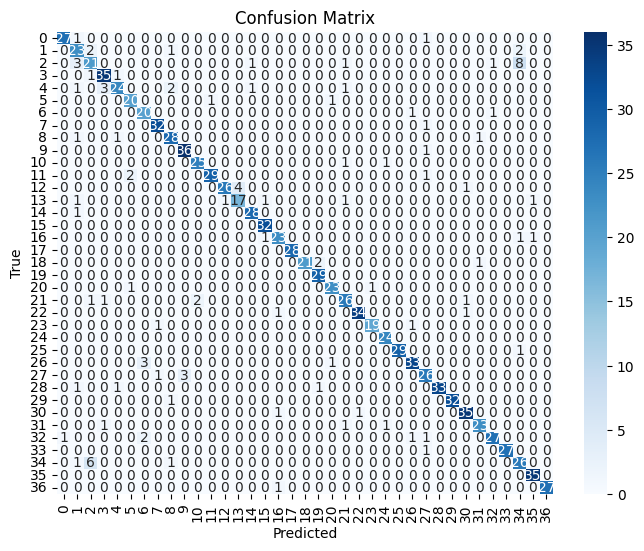

In [8]:
model.eval()
yhat = []
true_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch in tqdm(enumerate(test_loader), desc="Test", total=len(test_loader)):
        _, (imgs, labels) = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        yhat += predicted.detach().cpu()
        true_labels += labels.detach().cpu()

    accuracy = correct / total

print(f"Test Accuracy = {accuracy * 100:.3f}%")
plot_confusion_matrix(true_labels, yhat)